In [1]:
"""
*Filename: DeepNetTrainer
*Description: The original Deep Sets Trainer file which uses the standard DeepSets architecture and 
the base track and jet features to regress the bhadron features
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""

'\n*Filename: DeepNetTrainer\n*Description: The original Deep Sets Trainer file which uses the standard DeepSets architecture and \nthe base track and jet features to regress the bhadron features\nDate: 16/02/2023\nAuthor: Kaylen Smith Darnbrook\n'

In [69]:
#Starts by importing the relevant python modules
import DeepSetNeuralNetArchitecture as DSNNA
import os
from sklearn.feature_selection import mutual_info_regression
from tensorflow_probability import distributions
import seaborn as sns
import keras.backend as k
from keras import callbacks
import keras
import numpy as np
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Format the style and format of the matplotlib plots
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text', usetex=False)
plt.rc('font', family='Times New Roman')
%config InlineBackend.print_figure_kwargs = {'facecolor': "w"}


In [4]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")


In [5]:
# Initial parameters
# This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MASKVAL = -999
MAXTRACKS = 32  # This value is the maximum number of tracks allowed per event
BATCHSIZE = 512  # This is the batch size of the mini batches used during training
EPOCHS = 200  # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 1e20  # This is the maximum number of events that will the program will accept
LR = 1e-4 # This is the default learning rate


In [6]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores")
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
    
#Plots the mutual information scores.
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Informarion Scores")


In [7]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta", "AnalysisAntiKt4TruthJets_ghostB_phi"]


In [8]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features, entry_stop=MAXEVENTS)

In [19]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [20]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ", len(track_features))

The number of jets to train on is:  141329
The number of track features is:  8


In [21]:
# Select tracks from the events
tracks = events[track_features]

# Match the tracks to the jets
matchedtracks = tracks[DSNNA.Match_Tracks(jets, tracks)]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

In [22]:
# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:, 0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:, 0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi], axis = -1)
# Combine the momentum, eta and phi for each jet into one array
bhads = np.stack([bhads_pt, bhads_eta, bhads_phi], axis=-1)

# Display the number of target features the neural network will predict
print("There are {} outputs".format(np.shape(bhads)[1]))
matchedtracks = matchedtracks[bjets]
# Display the number of target features the neural network will use in it's predictions
print("There are {} inputs".format(np.shape(matchedtracks)[1]))


There are 3 outputs
There are 32 inputs


In [23]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [24]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
# Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p, matchedtracks[:, :, 3:].to_numpy()], axis=2)

/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:104: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [25]:
#Standardize the track inputs
Scaler = StandardScaler()
Num_events, Num_tracks, Num_features = np.shape(tracks)
tracks = np.reshape(tracks, newshape=(-1, Num_features))
tracks = Scaler.fit_transform(tracks)
tracks = np.reshape(tracks, newshape=(Num_events, Num_tracks, Num_features))

In [26]:
#Calculate the momentum fractions for the bhadrons
bhads_scaled_px = bhads[:,0]/b_jets[:,0]
bhads_scaled_py = bhads[:,1]/b_jets[:,1]
bhads_scaled_pz = bhads[:,2]/b_jets[:,2]
print(bhads_scaled_px.shape)
bhads_scaled = np.stack([bhads_scaled_px,bhads_scaled_py, bhads_scaled_pz], axis = -1)
print(bhads_scaled.shape)

(68143,)
(68143, 3)


In [27]:
# Split the data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(
    tracks, bhads_scaled, train_size=0.8, random_state=42)


In [28]:
# Check for the of the training and validation sets
print(np.shape(X_train), np.shape(X_valid))
print(np.shape(y_train), np.shape(y_valid))

(54514, 32, 8) (13629, 32, 8)
(54514, 3) (13629, 3)


In [30]:
# Cyclical Learning Rate Scheduler:
steps_per_epoch = len(X_train)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4,
                                          maximal_learning_rate=0.001,
                                          scale_fn=lambda x: 1/(2**(x-1)),
                                          step_size=2.0 * steps_per_epoch
                                          )


class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs = []

    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer() - self.starttime)


# Builds the deep neural network
track_layers = [34,34,34,34,34]
jet_layers = [64,64,64,64,64]

len1 = [len(track_features)]+track_layers
print(len1)

# Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR, clipnorm= 6)
optimizer_Constant = tf.keras.optimizers.SGD(
    learning_rate=1e-4, momentum=0.9, clipnorm=1.0, nesterov=True)

# Builds the DeepSet Neural Network
DeepNet = DSNNA.DeepSetNeuralNetwork(
    [len(track_features)] + track_layers, jet_layers, np.shape(y_train)[1], optimizer)

[8, 34, 34, 34, 34, 34]


2023-02-16 11:54:44.757826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-16 11:54:44.757860: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-16 11:54:44.757880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2023-02-16 11:54:44.759318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
print(DeepNet.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking (Masking)           (None, None, 8)           0         
                                                                 
 time_distributed (TimeDistr  (None, None, 8)          72        
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, None, 8)          32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, None, 34)         306       
 tributed)                                                       
                                                             

In [34]:
# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/DeepNetWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq=100*BATCHSIZE)
# Timer
cb = TimingCallback()

# Weight&Biases Callback:
#Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = (X_train,y_train), validation_data = (X_valid,y_valid), log_batch_frequency = 5)

# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0=LR, s=30)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(
    exponential_decay_fn)


In [36]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=40,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=10, min_lr=1e-6)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/DeepNetWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 100*BATCHSIZE)
#Timer
cb = TimingCallback()
         
# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0 = LR,s = 30)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [37]:
# Train the neural network using MSE
history = DeepNet.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCHSIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping,reduce_learn_on_plateau,cb,cp_callback],
)


Epoch 1/200
107/107 [==============================] - 11s 29ms/step - loss: 23.3837 - val_loss: 14.1194 - lr: 1.0000e-04
Epoch 2/200
107/107 [==============================] - 2s 23ms/step - loss: 22.6307 - val_loss: 14.1763 - lr: 1.0000e-04
Epoch 3/200
107/107 [==============================] - 2s 23ms/step - loss: 22.2290 - val_loss: 15.2944 - lr: 1.0000e-04
Epoch 4/200
107/107 [==============================] - 2s 23ms/step - loss: 21.9300 - val_loss: 15.2659 - lr: 1.0000e-04
Epoch 5/200
107/107 [==============================] - 3s 23ms/step - loss: 21.6573 - val_loss: 15.2058 - lr: 1.0000e-04
Epoch 6/200
107/107 [==============================] - 3s 24ms/step - loss: 21.3790 - val_loss: 14.5595 - lr: 1.0000e-04
Epoch 7/200
107/107 [==============================] - 3s 23ms/step - loss: 21.1327 - val_loss: 14.8035 - lr: 1.0000e-04
Epoch 8/200
107/107 [==============================] - 3s 24ms/step - loss: 20.8780 - val_loss: 15.2417 - lr: 1.0000e-04
Epoch 9/200
107/107 [==========

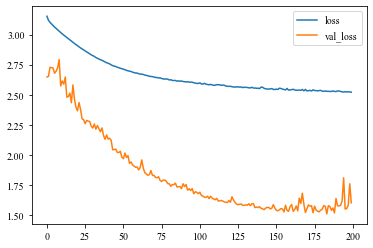

In [43]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss", "val_loss"]]).plot()
history_df.to_csv(
    '/home/physics/phujdj/DeepLearningParticlePhysics/historyN.csv')


In [44]:
#Print the time it took for the neural network to train
print(sum(cb.logs))

511.6528708639089


In [45]:
# Output to the console the minimum epoch
print("Minimum validation loss: {}".format(history_df["loss"].min()))

Minimum validation loss: 12.443620681762695


In [46]:
# Evaluate the entire performance of the model
loss = DeepNet.evaluate(tracks, bhads, verbose=2)
print("The Loaded DeepNet has loss: ", loss)

2130/2130 - 4s - loss: 15868383232.0000 - 4s/epoch - 2ms/step
The Loaded DeepNet has loss:  15868383232.0


In [49]:
#Rescale the predictions
Predictions = DeepNet.predict(tracks)
Predictions_px = Predictions[:,0] * b_jets[:,0]
Predictions_py = Predictions[:,1] * b_jets[:,1]
Predictions_pz = Predictions[:,2] * b_jets[:,2]
print(Predictions.shape)

2130/2130 [==============================] - 4s 2ms/step
(68143, 3)


In [ ]:
#Below calculates the resolutions, resolutions scaled by 
#standard deviation of bhads.

In [50]:
Error_px = bhads[:,0] - Predictions_px
Pull_bhads_px = Error_px/np.std(bhads[:,0])

In [51]:
Error_py = bhads[:,1] - Predictions_py
Pull_bhads_py = Error_py/np.std(bhads[:,1])

In [52]:
Error_pz = bhads[:,2] - Predictions_pz
Pull_bhads_pz = Error_pz/np.std(bhads[:,2])

In [ ]:
#Plot the results:

412.686282019608
108144.82694458983


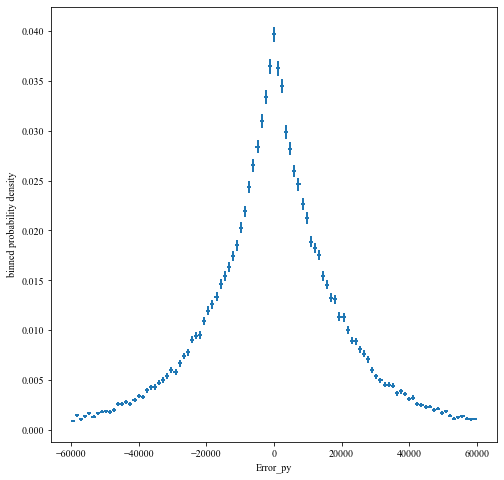

In [57]:
print(np.mean(Error_px))
print(np.std(Error_px))
binneddensity(Error_px, fixedbinning(-60000,60000,100),xlabel = "Error_py")

-1184.8276183916516
157542.45477663077


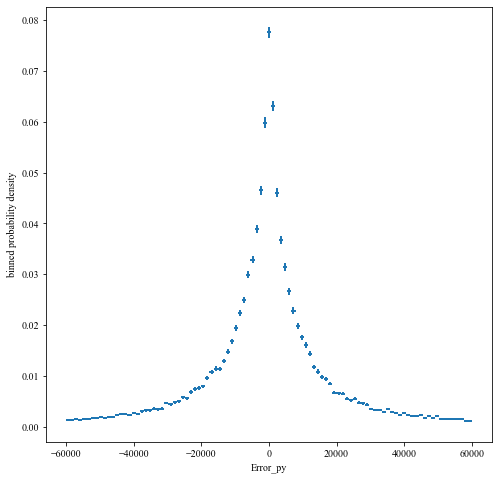

In [58]:
print(np.mean(Error_py))
print(np.std(Error_py))
binneddensity(Error_py, fixedbinning(-60000,60000,100),xlabel = "Error_py")

-11720.931113825063
200844.32611265092


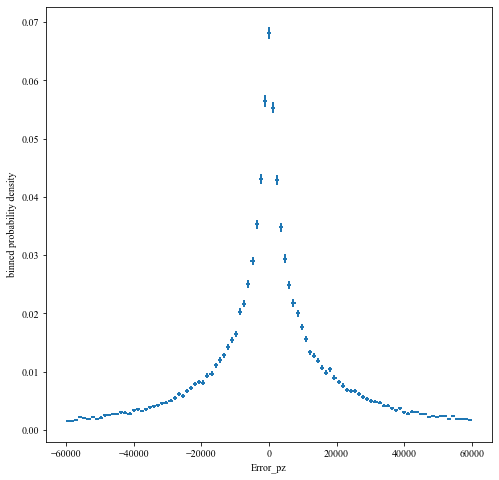

In [59]:
print(np.mean(Error_pz))
print(np.std(Error_pz))
binneddensity(Error_pz, fixedbinning(-60000,60000,100),xlabel = "Error_pz")

0.00633039341605163
1.6588855270879757


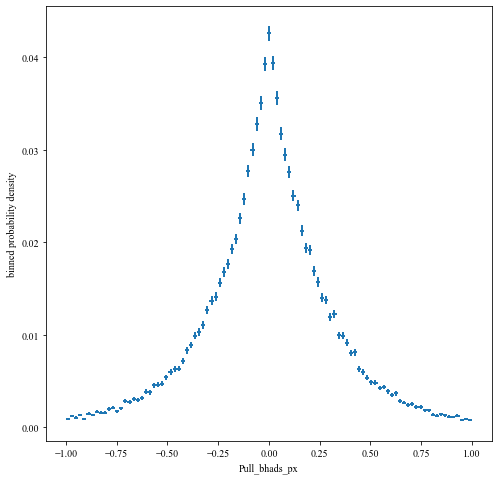

In [67]:
print(np.mean(Pull_bhads_px))
print(np.std(Pull_bhads_px))
binneddensity(Pull_bhads_px, fixedbinning(-1,1,100),xlabel = "Pull_bhads_px")

-0.018110381389166794
2.4080751467149026


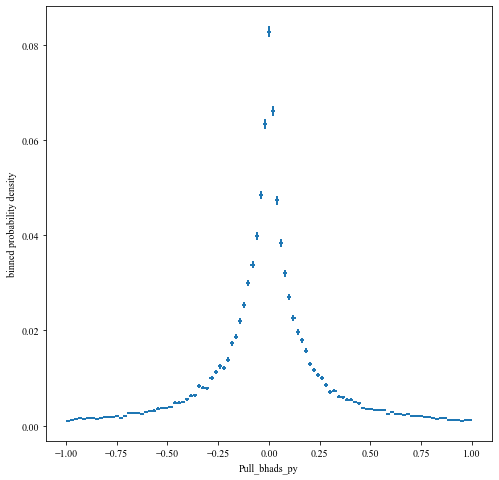

In [66]:
print(np.mean(Pull_bhads_py))
print(np.std(Pull_bhads_py))
binneddensity(Pull_bhads_py, fixedbinning(-1,1,100),xlabel = "Pull_bhads_py")

-0.05929451963445168
1.0160428145600089


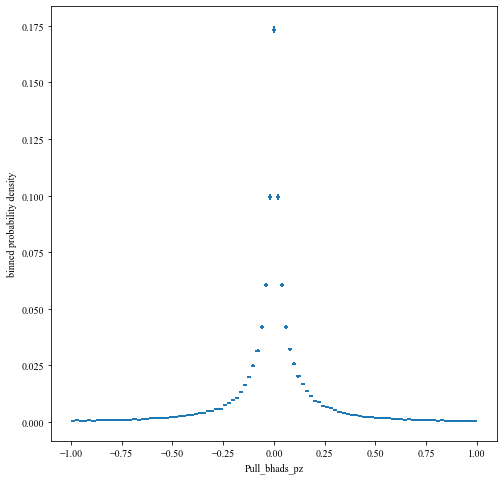

In [65]:
print(np.mean(Pull_bhads_pz))
print(np.std(Pull_bhads_pz))
binneddensity(Pull_bhads_pz, fixedbinning(-1,1,100),xlabel = "Pull_bhads_pz")

In [ ]:
#Belows plots the scatter plots of the true bhadron targets vs the neural networks predicted bhadron targets

Text(0, 0.5, 'The predicted X momenta of b hadron jets')

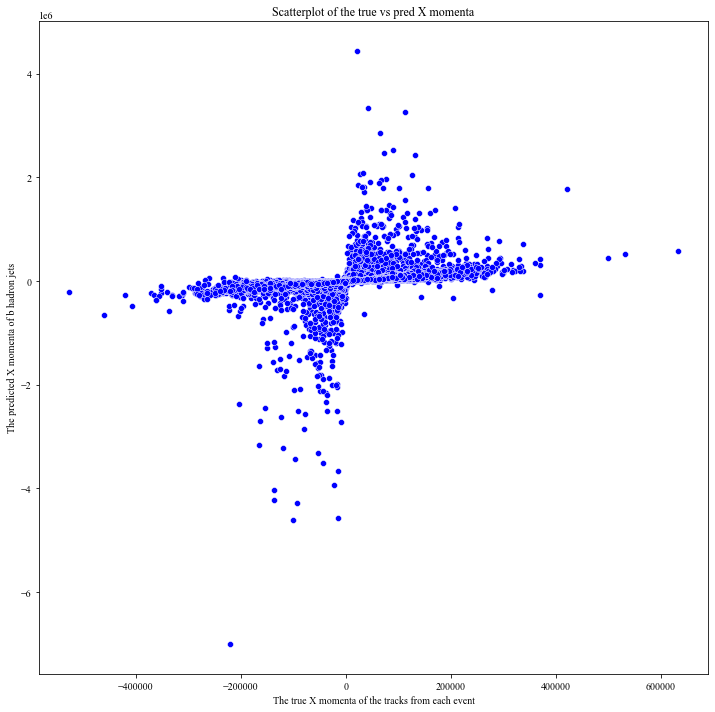

In [70]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions_px,
    x = bhads[:,0],
    color = "blue"
)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")

Text(0, 0.5, 'The predicted Y momenta of b hadron jets')

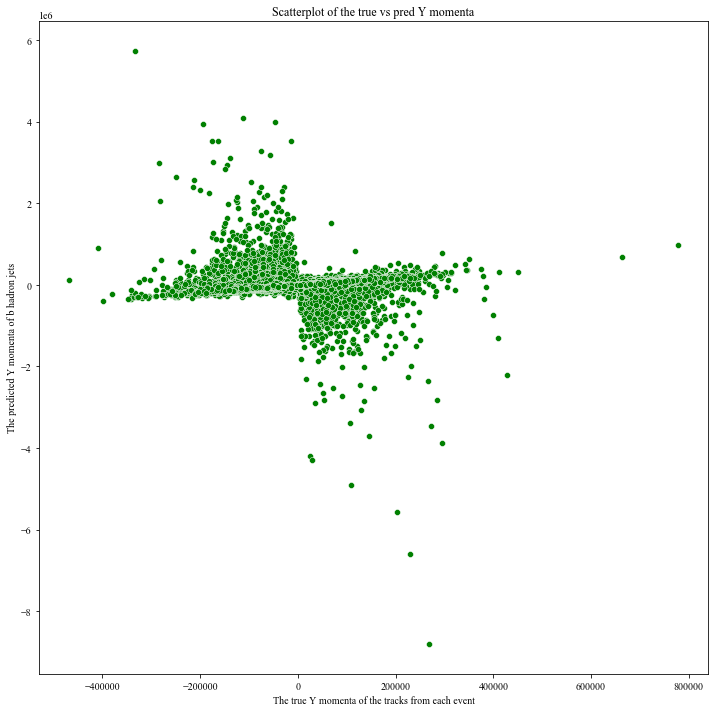

In [71]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions_py,
    x = bhads[:,1],
    color = "green"
)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlabel("The true Y momenta of the tracks from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")

Text(0, 0.5, 'The predicted Z momenta of b hadron jets')

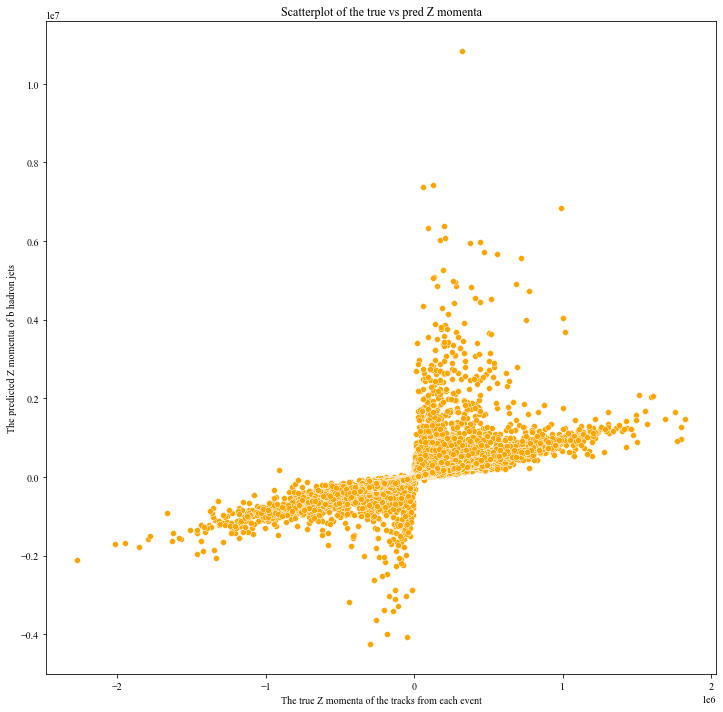

In [72]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions_pz,
    x = bhads[:,2],
    color = "orange"
)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the tracks from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")

In [87]:
#Gets the outputs coming from the sum layer
get_sum_layer_output = k.function([DeepNet.layers[0].input],
                                  [DeepNet.layers[13].output])
layer_output = get_sum_layer_output(tracks)[0]
print(layer_output.shape)
layer_output_jet = np.mean(layer_output, axis  = 1)

(68143, 34)


In [96]:
#Reverses the output of the sum layer and bhad targets
layer_output_reverse = np.reshape(layer_output, (34,-1))
bhads_output = np.reshape(bhads, (3,-1))

#Computes the average across the layer
layer_output_average = np.mean(layer_output_reverse, axis = -1)
HistLayer = np.stack([np.arange(34), layer_output_average])

#Forms a matrix consists of the features and targets
X = np.concatenate([layer_output_reverse, bhads_output])
X[np.shape(X)[0] - np.shape(bhads_output)[0]:,:]

#Calculates the pearson correlation matrix
Pearson_Correlation_Matrix = np.corrcoef(X)

In [97]:
#Extracts the correlation between the bhadron x, and z momenta and the features coming out the sum layer. 
#Then produces histograms for them.
Correlation_X = Pearson_Correlation_Matrix[:32,32:][:,0]
HistX = np.stack([np.arange(32), Correlation_X])

Correlation_Y = Pearson_Correlation_Matrix[:32,32:][:,1]
HistY = np.stack([np.arange(32), Correlation_Y])

Correlation_Z = Pearson_Correlation_Matrix[:32,32:][:,2]
HistZ = np.stack([np.arange(32), Correlation_Z])

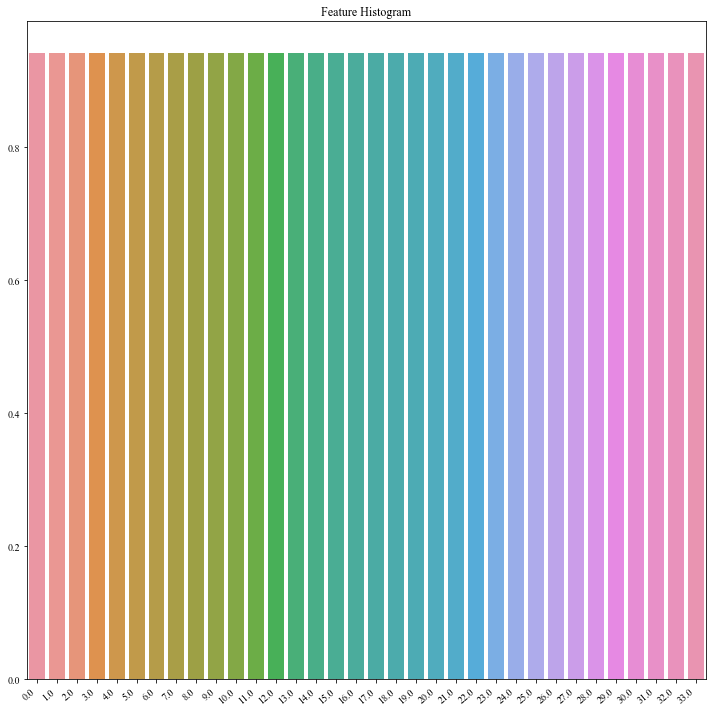

In [98]:
#Plots the feature histogram coming out from the sum layer averaged arcoss the tracks and then averaged across the jets
plt.figure(figsize = (10,10))
ax = sns.barplot(x = HistLayer[0,:], y = HistLayer[1,:])
ax.set_title("Feature Histogram")
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right') 
plt.tight_layout()

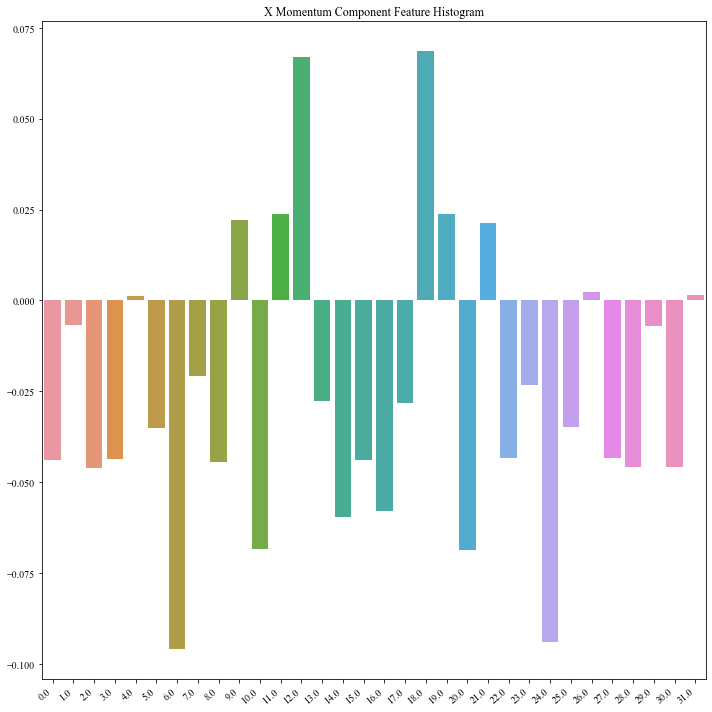

In [99]:
#Displays the histogram of correlations between the bhadron's x momentum and the features coming out the sum layer.
plt.figure(figsize = (10,10))
ax = sns.barplot(x = HistX[0,:], y = HistX[1,:])
ax.set_title("X Momentum Component Feature Histogram")
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right') 
plt.tight_layout()


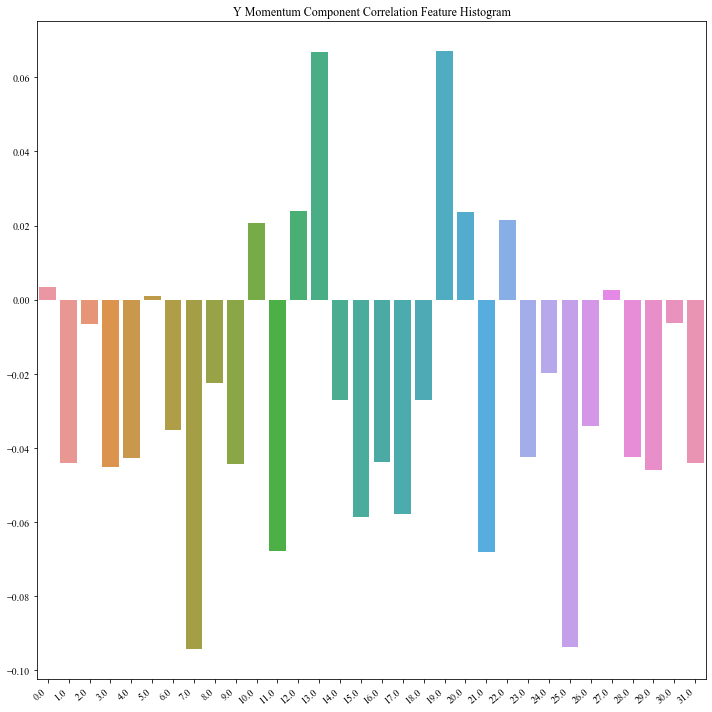

In [100]:
#Displays the histogram of correlations between the bhadron's y momentum and the features coming out the sum layer.
plt.figure(figsize = (10,10))
ax = sns.barplot(x = HistY[0,:], y = HistY[1,:])
ax.set_title("Y Momentum Component Correlation Feature Histogram")
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right') 
plt.tight_layout()

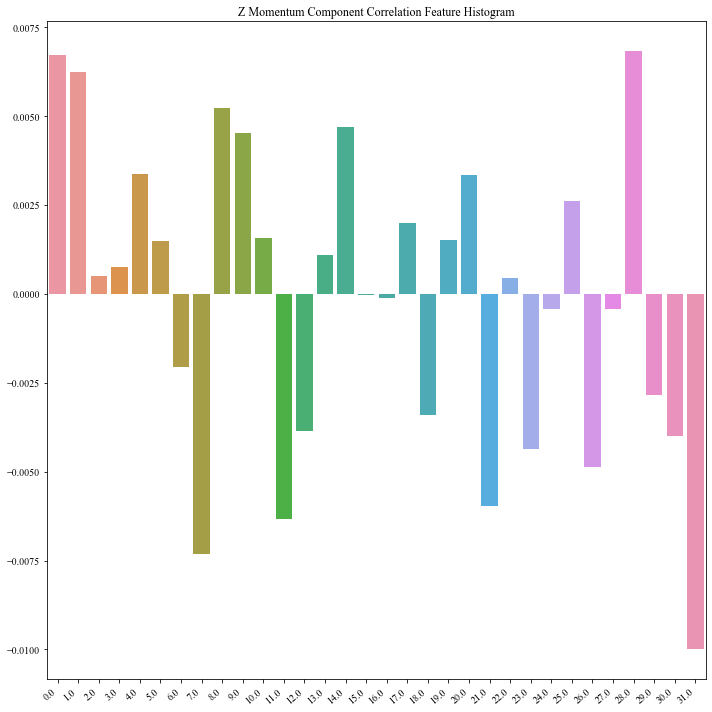

In [101]:
#Displays the histogram of correlations between the bhadron's z momentum and the features coming out the sum layer.
plt.figure(figsize = (10,10))
ax = sns.barplot(x = HistZ[0,:], y = HistZ[1,:])
ax.set_title("Z Momentum Component Correlation Feature Histogram")
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right') 
plt.tight_layout()

In [102]:
#Calculates the mutual information scores between the features coming out the sum layer and the bhadron x momenta
mi_scores_px_momentum = make_mi_scores(layer_output, bhads[:,0])
print(mi_scores_px_momentum)

7     0.382221
21    0.352690
11    0.291611
13    0.289769
10    0.281627
32    0.249355
22    0.234853
12    0.218585
29    0.194509
24    0.168032
18    0.166404
17    0.157391
3     0.135436
9     0.108070
14    0.094890
2     0.088648
8     0.077399
23    0.075427
16    0.066009
4     0.065281
28    0.061661
30    0.061547
6     0.054776
5     0.053415
25    0.045229
1     0.044926
19    0.035774
0     0.034728
33    0.031568
20    0.030182
15    0.026449
31    0.023650
27    0.021589
26    0.021483
Name: MI Scores, dtype: float64


In [103]:
#Calculates the mutual information scores between the features coming out the sum layer and the bhadron y momenta
mi_scores_py_momentum = make_mi_scores(layer_output, bhads[:,1])
print(mi_scores_py_momentum)

5     0.103597
1     0.069941
22    0.056999
7     0.055532
25    0.039211
21    0.038265
30    0.037712
9     0.035626
10    0.032015
32    0.029027
8     0.028226
29    0.027843
3     0.027427
6     0.027357
28    0.026983
18    0.026936
12    0.026713
19    0.026116
17    0.025792
4     0.025659
2     0.024575
11    0.023974
16    0.023186
24    0.023082
23    0.022047
14    0.021844
13    0.021192
20    0.020446
33    0.020122
31    0.019770
27    0.017327
0     0.014583
26    0.013997
15    0.012716
Name: MI Scores, dtype: float64


In [104]:
#Calculates the mutual information scores between the features coming out the sum layer and the bhadron z momenta
mi_scores_pz_momentum = make_mi_scores(layer_output, bhads[:,2])
print(mi_scores_pz_momentum)

23    0.514213
19    0.479201
31    0.469880
28    0.466135
0     0.461737
6     0.440606
30    0.439636
4     0.413661
33    0.372157
14    0.336040
9     0.323502
2     0.298869
17    0.290544
20    0.283961
25    0.281273
1     0.280567
3     0.270421
16    0.266320
8     0.263173
27    0.233573
15    0.219698
12    0.197276
18    0.194281
26    0.189791
13    0.173276
24    0.166649
29    0.154282
22    0.141496
10    0.126934
21    0.124799
11    0.116972
32    0.113941
5     0.105008
7     0.102652
Name: MI Scores, dtype: float64


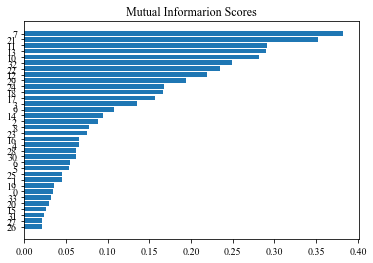

In [105]:
#Displays the mutual information scores between the output of the sum layer and the bhadron x momenta
plt.Figure(dpi=200, figsize=(100, 100))
plot_mi_scores(mi_scores_px_momentum)

In [106]:
mi_scores_px_momentum =  make_mi_scores(Predictions, bhads[:,0])
print(mi_scores_px_momentum)

2    0.157121
1    0.059341
0    0.041958
Name: MI Scores, dtype: float64


In [107]:
mi_scores_py_momentum =  make_mi_scores(Predictions, bhads[:,1])
print(mi_scores_py_momentum)

2    0.021095
1    0.015264
0    0.012183
Name: MI Scores, dtype: float64


In [108]:
mi_scores_pz_momentum =  make_mi_scores(Predictions, bhads[:,2])
print(mi_scores_px_momentum)

2    0.157121
1    0.059341
0    0.041958
Name: MI Scores, dtype: float64
